### This notebook contains insturctions on how to download the dataset for StlyeSwap and code for processing it. The dataset can be found on [google drive](https://drive.google.com/file/d/1AJBWrOENyssJX1zK6VtbT-mMC8_xXbR_/view?usp=sharing) and contains test and train images. 

In [20]:
import os
import json
import numpy as np
import jsonlines
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
print("Current working dir:", os.getcwd())

Current working dir: /sfs/gpfs/tardis/home/wbd3kw/DS6050/StyleSwap


In [12]:
#look into the first few lines of the train_ann_file.jsonl
with open('DFMM_Dataset/DFMM-Spotlight/mask_ann/train_ann_file.jsonl', 'r') as f:
    lines = f.readlines()

#parse the first few JSON objects
for line in lines[:3]:
    ann = json.loads(line)
    print(json.dumps(ann, indent=2))


{
  "image": "MEN-Denim-id_00000080-01_7_additional.png",
  "mask": "MEN-Denim-id_00000080-01_7_additional_mask_0.png",
  "text": "cotton gray upper clothing"
}
{
  "image": "MEN-Denim-id_00000080-01_7_additional.png",
  "mask": "MEN-Denim-id_00000080-01_7_additional_mask_1.png",
  "text": "long cotton plaid lower clothing"
}
{
  "image": "MEN-Denim-id_00000089-01_7_additional.png",
  "mask": "MEN-Denim-id_00000089-01_7_additional_mask_0.png",
  "text": "cotton red sleeveless tank top"
}


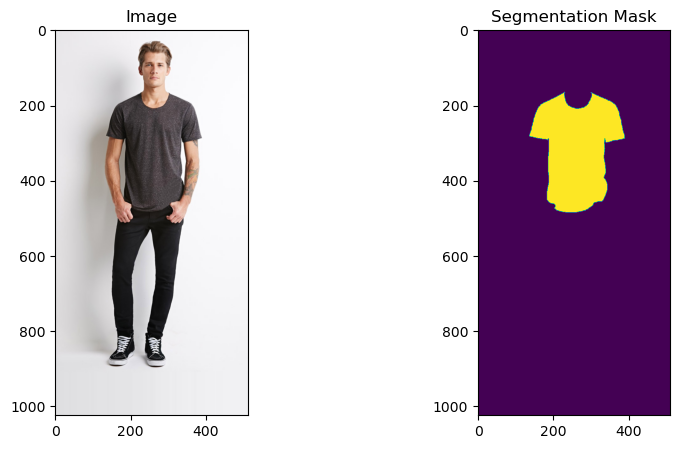

In [28]:
#load in a sample image and its mask
img_path = 'DFMM_Dataset/DFMM-Spotlight/train_images/MEN-Denim-id_00000080-01_7_additional.png'
mask_path = 'DFMM_Dataset/DFMM-Spotlight/mask/MEN-Denim-id_00000080-01_7_additional_mask_0.png'

image = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Segmentation Mask')
plt.show()


In [ ]:
#spotlight 
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


_DESCRIPTION = """\
A fashion image-region-text pair dataset called DFMM-Spotlight, highlighting local cloth.

The DFMMSpotlightDataset class subclasses Hugging Face's GeneratorBasedBuilder which is used to define how a dataset is structured. The structure includes features such as image, mask and text which are the three important components to using this data. 
"""




    def _split_generators(self, dl_manager):
        data_dir = '/path/to/DFMM-Spotlight'
        return [
            datasets.SplitGenerator(
                name=datasets.Split.TRAIN,
                # These kwargs will be passed to _generate_examples
                gen_kwargs={
                    "filepath": data_dir,
                    "split": "train",
                },
            ),
            datasets.SplitGenerator(
                name=datasets.Split.TEST,
                # These kwargs will be passed to _generate_examples
                gen_kwargs={
                    "filepath": data_dir,
                    "split": "test",
                },
            ),
        ]

    # method parameters are unpacked from `gen_kwargs` as given in `_split_generators`
    def _generate_examples(self, filepath, split):
        img_path = os.path.join(filepath, f'{split}_images')
        mask_path = os.path.join(filepath, 'mask')

        images = []
        masks = []
        texts = []
        with jsonlines.open(os.path.join(filepath, 'mask_ann', f'{split}_ann_file.jsonl'), 'r') as reader:
            for row in reader:
                images.append(row['image'])
                masks.append(row['mask'])
                texts.append(row['text'])

        dataset_len = len(images)
        for i in range(dataset_len):
            yield i, {
                        'image': Image.open(os.path.join(img_path, images[i])),
                        'mask': Image.open(os.path.join(mask_path, masks[i])),
                        "text": texts[i],
  

In [16]:
#defining paths but change this to your own paths 
DATA_DIR = "DFMM_Dataset/DFMM-Spotlight"
SPLIT = "train"  # can also be "test"

IMG_DIR = os.path.join(DATA_DIR, f"{SPLIT}_images")  
MASK_DIR = os.path.join(DATA_DIR, "mask")
ANN_PATH = os.path.join(DATA_DIR, "mask_ann", f"{SPLIT}_ann_file.jsonl")

# we are only using 10% of the dataset rn cause the entire dataset will take forever to run with no gpus 
SAMPLE_FRACTION = 0.1


In [21]:
annotations = []

with jsonlines.open(ANN_PATH, mode='r') as reader:
    for row in reader:
        annotations.append(row)

#suffle and take a 20% sample
random.shuffle(annotations)
sample_size = int(len(annotations) * SAMPLE_FRACTION)
annotations_subset = annotations[:sample_size]

## UNCOMMENT THE BOTTOM LINE TO USE THE ENTIRE DATASET ##
# annotations_subset = annotations


In [22]:
examples = []

for row in tqdm(annotations_subset, desc="Loading examples"):
    image_path = os.path.join(IMG_DIR, row["image"])
    mask_path = os.path.join(MASK_DIR, row["mask"])

    try:
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
    except Exception as e:
        print(f"Error loading image {image_path} or mask {mask_path}: {e}")
        continue

    examples.append({
        "image": image,
        "mask": mask,
        "text": row["text"]
    })

#ten percent took like a minute to load and is 2137 images 

Loading examples: 100%|██████████| 2137/2137 [01:17<00:00, 27.51it/s]


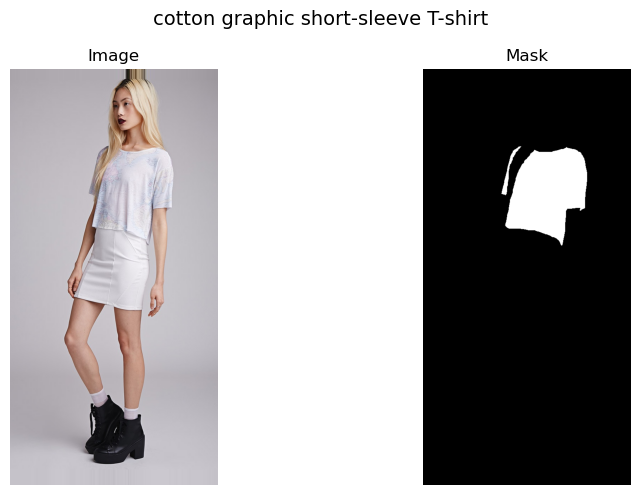

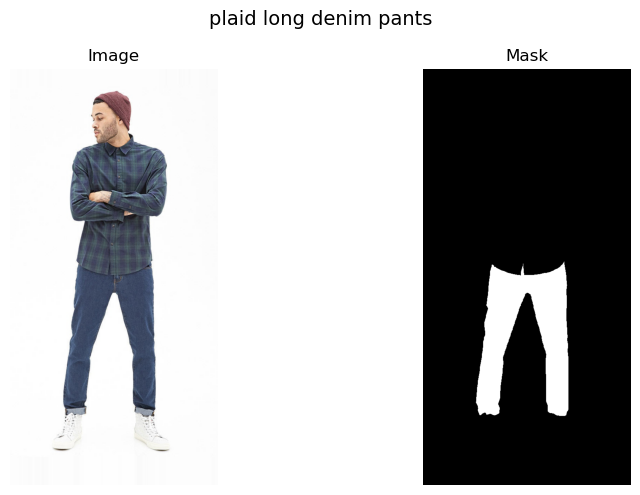

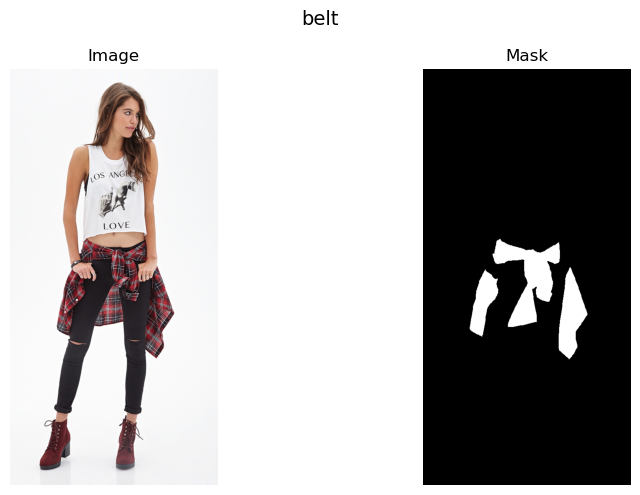

In [26]:
def show_example(example):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(example["image"])
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(example["mask"], cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis("off")

    plt.suptitle(example["text"], fontsize=14)
    plt.tight_layout()
    plt.show()

# print 3 random examples
for _ in range(3):
    show_example(random.choice(examples))


The first file in dataset was loading in the data, applying transformations and downsampling, reading in, images, text, and masks, and showing some samples of image-mask pairs. 

The second file is to load in annotations and making the data compatible with pytorch for further training. 

The ipynb file loads in images and masks, visualizes some samples, and prints some examples using 10% of the dataset. We are also downsampling images that have a factor larger than 1 to be half the size. 

In [33]:
#need to downsample here but should we? 
from PIL import Image
import os

def check_image_size(image_path):
    try:
        with open(image_path, 'rb') as f:
            image = Image.open(f)
            width, height = image.size
            print(f"Image: {image_path} - Width: {width}, Height: {height}")
            return width, height
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None

# Example usage for a specific image
img_path = 'DFMM_Dataset/DFMM-Spotlight/train_images/MEN-Denim-id_00000080-01_7_additional.png'
check_image_size(img_path)




Image: DFMM_Dataset/DFMM-Spotlight/train_images/MEN-Denim-id_00000080-01_7_additional.png - Width: 512, Height: 1024


(512, 1024)


### Source 
@inproceedings{wang2024texfit,
  title={TexFit: Text-Driven Fashion Image Editing with Diffusion Models},
  author={Wang, Tongxin and Ye, Mang},
  booktitle={Proceedings of the AAAI Conference on Artificial Intelligence},
  volume={38},
  number={9},
  pages={10198--10206},
  year={2024}
}